In [15]:
import pandas as pd
import cptac
import scipy.stats as stats
import numpy as np
import statsmodels.stats.multitest as ssm
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [16]:
class1_tRNA_synthases = pd.read_csv('data/class1_trna_synthases.csv')
class1_tRNA_synthases = list(class1_tRNA_synthases['Approved symbol'])

In [17]:
class2_tRNA_synthases = pd.read_csv('data/class2_trna_synthases.csv')
class2_tRNA_synthases = list(class2_tRNA_synthases['Approved symbol'])

In [18]:
class1_tRNA_synthases.extend(class2_tRNA_synthases)
tRNA_synthases = class1_tRNA_synthases

In [19]:
ccrcc = cptac.Ccrcc()
en = cptac.Endometrial()
luad = cptac.Luad()
lscc = cptac.Lscc()
hnscc = cptac.Hnscc()

cptac warning: The LSCC data is currently strictly reserved for CPTAC investigators. Otherwise, you are not authorized to access these data. Additionally, even after these data become publicly available, they will be subject to a publication embargo (see https://proteomics.cancer.gov/data-portal/about/data-use-agreement or enter cptac.embargo() to open the webpage for more details). (<ipython-input-19-7685cf93750a>, line 4)


In [20]:
cancer_list = [ccrcc, en, luad, lscc, hnscc]
cancer_names = ['ccrcc', 'en', 'luad', 'lscc', 'hnscc']

In [21]:
cancer_dfs = []
for cancer, name in zip(cancer_list, cancer_names):    
    trans_norm_df = cancer.get_transcriptomics(tissue_type = 'normal')
    if isinstance(trans_norm_df.columns, pd.MultiIndex):
        trans_norm_df = trans_norm_df.droplevel('Database_ID', axis = 1)
    trans_norm_df['patient_ID'] = trans_norm_df.index
    trans_norm_df = trans_norm_df.melt(id_vars = 'patient_ID', var_name = 'Gene', value_name = 'Transcriptomics')
    trans_norm_df['Tissue'] = ['normal'] * len(trans_norm_df)

    trans_tum_df = cancer.get_transcriptomics(tissue_type = 'tumor')
    if isinstance(trans_tum_df.columns, pd.MultiIndex):
        trans_tum_df = trans_norm_df.droplevel('Database_ID', axis = 1)
    trans_tum_df['patient_ID'] = trans_tum_df.index
    trans_tum_df = trans_tum_df.melt(id_vars = 'patient_ID', var_name = 'Gene', value_name = 'Transcriptomics')
    trans_tum_df['Tissue'] = ['tumor'] * len(trans_tum_df)
    trans_df = pd.concat([trans_norm_df, trans_tum_df])

    prot_norm_df = cancer.get_proteomics(tissue_type='normal')
    if isinstance(prot_norm_df.columns, pd.MultiIndex):
        prot_norm_df = prot_norm_df.droplevel('Database_ID', axis = 1)
    prot_norm_df['patient_ID'] = prot_norm_df.index
    prot_norm_df = prot_norm_df.melt(id_vars = 'patient_ID', var_name = 'Gene', value_name = 'Proteomics')
    prot_norm_df['Tissue'] = ['normal'] * len(prot_norm_df)

    prot_tum_df = cancer.get_proteomics(tissue_type='tumor')
    if isinstance(prot_tum_df.columns, pd.MultiIndex):
        prot_tum_df = prot_tum_df.droplevel('Database_ID', axis = 1)
    prot_tum_df['patient_ID'] = prot_tum_df.index
    prot_tum_df = prot_tum_df.melt(id_vars = 'patient_ID', var_name = 'Gene', value_name = 'Proteomics')
    prot_tum_df['Tissue'] = ['tumor'] * len(prot_tum_df)

    trans_df = pd.concat([trans_norm_df, trans_tum_df])
    prot_df = pd.concat([prot_norm_df, prot_tum_df])

    cancer_df = pd.merge(trans_df, prot_df, on = ['patient_ID', 'Gene', 'Tissue'])
    cancer_df = cancer_df.dropna()
    cancer_df['Cancer'] = [name] * len(cancer_df)
    cancer_dfs.append(cancer_df)
df = pd.concat(cancer_dfs)
df


,patient_ID,Gene,Transcriptomics,Tissue,Proteomics,Cancer
0,C3L-00004.N,A1BG,0.859821,normal,0.291127,ccrcc
1,C3L-00010.N,A1BG,0.824992,normal,-0.579658,ccrcc
2,C3L-00011.N,A1BG,0.673249,normal,-0.096200,ccrcc
3,C3L-00026.N,A1BG,3.043751,normal,-0.209196,ccrcc
4,C3L-00079.N,A1BG,0.801038,normal,-0.395915,ccrcc
...,...,...,...,...,...,...
1766693,C3N-04275,ZZZ3,11.520000,tumor,18.577359,hnscc
1766695,C3N-04277,ZZZ3,11.510000,tumor,19.897997,hnscc
1766696,C3N-04278,ZZZ3,11.220000,tumor,19.898459,hnscc
1766697,C3N-04279,ZZZ3,11.330000,tumor,19.755773,hnscc


In [22]:
tRNA_synthase_df = df[df.Gene.isin(tRNA_synthases)]
tRNA_synthase_df

,patient_ID,Gene,Transcriptomics,Tissue,Proteomics,Cancer
1050,C3L-00004.N,AARS2,7.698287,normal,-0.077214,ccrcc
1051,C3L-00010.N,AARS2,8.320137,normal,0.226978,ccrcc
1052,C3L-00011.N,AARS2,8.093313,normal,0.277643,ccrcc
1053,C3L-00026.N,AARS2,6.779368,normal,0.155182,ccrcc
1054,C3L-00079.N,AARS2,5.912681,normal,-0.446350,ccrcc
...,...,...,...,...,...,...
1727891,C3N-04277,YARS2,9.600000,tumor,24.953122,hnscc
1727892,C3N-04278,YARS2,10.230000,tumor,25.476995,hnscc
1727893,C3N-04279,YARS2,9.790000,tumor,25.453730,hnscc
1727894,C3N-04280,YARS2,9.940000,tumor,25.297566,hnscc


In [23]:
rows = []
for cancer in pd.unique(tRNA_synthase_df.Cancer):
    for gene in pd.unique(tRNA_synthase_df.Gene):
        gene_df = tRNA_synthase_df[tRNA_synthase_df.Gene == gene]
        gene_df = gene_df[gene_df.Cancer == cancer]
        normal_prot = gene_df[gene_df.Tissue == 'normal'].Proteomics
        tumor_prot = gene_df[gene_df.Tissue == 'tumor'].Proteomics
        t_score, pval = stats.ttest_ind(normal_prot, tumor_prot)
        normal_avg = np.mean(normal_prot)
        tumor_avg = np.mean(tumor_prot)
        row = dict()
        row['Cancer'] = cancer
        row['Gene'] = gene
        row['Normal_avg'] = normal_avg
        row['Tumor_avg'] = tumor_avg
        row['delta_prot'] = tumor_avg - normal_avg
        row['t_score'] = t_score
        row['pval'] = pval
        rows.append(row)
tRNA_synthase_df = pd.DataFrame(rows)
tRNA_synthase_df = tRNA_synthase_df.dropna()
tRNA_synthase_df.pval = list(ssm.fdrcorrection(list(tRNA_synthase_df.pval))[1])
tRNA_synthase_df = tRNA_synthase_df[tRNA_synthase_df.pval < 0.05]
tRNA_synthase_df

,Cancer,Gene,Normal_avg,Tumor_avg,delta_prot,t_score,pval
0,ccrcc,AARS2,0.088979,0.015699,-0.073280,2.144152,4.608791e-02
1,ccrcc,CARS2,0.403209,-0.353018,-0.756227,14.467450,3.132854e-31
2,ccrcc,DARS2,0.539633,-0.538742,-1.078375,22.418536,1.054688e-52
3,ccrcc,EARS2,0.455096,-0.458784,-0.913880,17.688185,2.425253e-40
4,ccrcc,FARS2,0.443437,-0.375908,-0.819345,18.767700,3.069059e-43
...,...,...,...,...,...,...,...
86,hnscc,MARS2,22.277679,22.008024,-0.269654,5.299608,1.285389e-06
88,hnscc,PARS2,23.049814,22.807680,-0.242134,5.461126,6.739588e-07
90,hnscc,SARS2,25.440298,25.267631,-0.172667,3.474014,1.262595e-03
92,hnscc,VARS2,22.864986,22.740908,-0.124078,2.428666,2.400713e-02


In [24]:
tRNA_synthase_df = tRNA_synthase_df.melt(id_vars = ['Cancer', 'Gene', 't_score', 'pval'], value_vars = ['Normal_avg', 'Tumor_avg'], value_name= 'Average Proteomics', var_name = 'Tissue' )

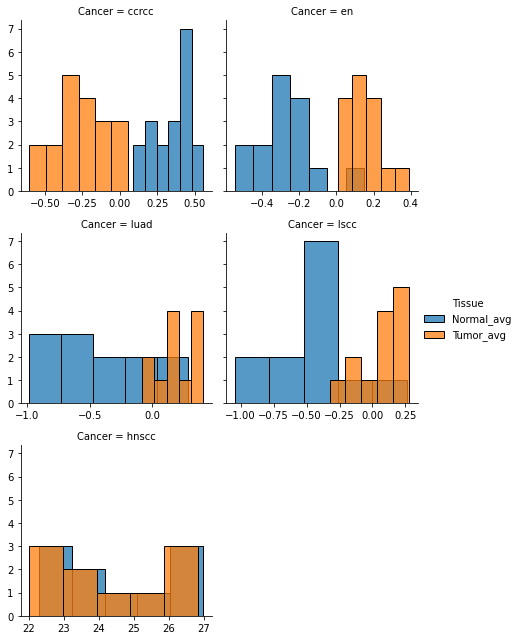

In [25]:
g = sns.FacetGrid(data = tRNA_synthase_df, col='Cancer', hue = 'Tissue', col_wrap = 2, sharex = False, legend_out=True)
g.map_dataframe(sns.histplot, x = 'Average Proteomics')
g.add_legend()

In [26]:
#in general, there is more tRNA synthase in tumors

In [35]:
RNA_transport_genes = []
file_name = 'data/kegg_rna_transport.txt'
with open(file_name) as file:
    for line in file:
        if 'RefSeq' in line:
            refseqs = re.search('RefSeq.*', line).group()
            refseqs = refseqs.split(';')[0]
            refseqs = refseqs.strip('RefSeq)')
            refseqs = refseqs.split(',')
            for gene in refseqs:
                gene = gene.strip()
                gene = gene.upper()
                if gene != '':
                    RNA_transport_genes.append(gene)
                    

In [42]:
RNA_transport_df = df[df.Gene.isin(RNA_transport_genes)]
rows = []
for cancer in pd.unique(RNA_transport_df.Cancer):
    for gene in pd.unique(RNA_transport_df.Gene):
        gene_df = RNA_transport_df[RNA_transport_df.Gene == gene]
        gene_df = gene_df[gene_df.Cancer == cancer]
        normal_prot = gene_df[gene_df.Tissue == 'normal'].Proteomics
        tumor_prot = gene_df[gene_df.Tissue == 'tumor'].Proteomics
        t_score, pval = stats.ttest_ind(normal_prot, tumor_prot)
        normal_avg = np.mean(normal_prot)
        tumor_avg = np.mean(tumor_prot)
        row = dict()
        row['Cancer'] = cancer
        row['Gene'] = gene
        row['Normal_avg'] = normal_avg
        row['Tumor_avg'] = tumor_avg
        row['delta_prot'] = tumor_avg - normal_avg
        row['t_score'] = t_score
        row['pval'] = pval
        rows.append(row)
RNA_transport_df = pd.DataFrame(rows)
RNA_transport_df = RNA_transport_df.dropna()
RNA_transport_df.pval = list(ssm.fdrcorrection(list(RNA_transport_df.pval))[1])
RNA_transport_df = RNA_transport_df[RNA_transport_df.pval < 0.05]
RNA_transport_df

C:\Users\nanel\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3583: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\nanel\anaconda3\lib\site-packages\numpy\core\_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\nanel\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1932: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


,Cancer,Gene,Normal_avg,Tumor_avg,delta_prot,t_score,pval
0,ccrcc,AAAS,-0.007879,0.166366,0.174245,-11.324108,3.129096e-22
1,ccrcc,ACIN1,0.245627,0.137860,-0.107767,3.186549,2.492955e-03
4,ccrcc,CLNS1A,-0.106720,0.217376,0.324095,-13.793194,2.530449e-29
5,ccrcc,CYFIP1,-0.182803,0.240624,0.423427,-20.312438,2.625646e-47
6,ccrcc,CYFIP2,0.304200,-0.117505,-0.421705,13.427067,2.870820e-28
...,...,...,...,...,...,...,...
775,hnscc,XPO1,26.967427,27.272734,0.305308,-7.944319,1.095964e-12
776,hnscc,XPO5,24.400707,25.152902,0.752196,-10.266269,1.696705e-18
777,hnscc,XPOT,25.833504,26.263021,0.429517,-8.271875,1.787506e-13
778,hnscc,EIF4G3,26.038578,26.297871,0.259293,-6.929251,2.597849e-10


In [43]:
rows = []
for gene in pd.unique(RNA_transport_df.Gene):
    gene_df = RNA_transport_df[RNA_transport_df.Gene == gene]
    avg_delta_prot = np.mean(gene_df.delta_prot)
    row = dict()
    row['Gene'] = gene
    row['avg_delta_prot'] = avg_delta_prot
    rows.append(row)
avg_RNA_transport_df = pd.DataFrame(rows)
avg_RNA_transport_df

,Gene,avg_delta_prot
0,AAAS,0.325862
1,ACIN1,0.510032
2,CLNS1A,0.547800
3,CYFIP1,-0.096755
4,CYFIP2,-0.107400
...,...,...
148,EIF3C,0.366901
149,EIF3F,0.573720
150,PABPC3,2.008764
151,SENP2,1.022649


In [45]:
from gprofiler import GProfiler
gp = GProfiler(return_dataframe=True)

In [47]:
old_genes = list(pd.unique(RNA_transport_df.Gene))
new_genes = list(gp.convert(query = old_genes, organism = 'hsapiens', target_namespace= 'uniprotswissprot_acc').converted)
for gene, ID in zip(old_genes, new_genes):
    s = ID
    gene_df = RNA_transport_df[RNA_transport_df.Gene == gene]
    avg_delta_prot = np.mean(gene_df.delta_prot)
    if avg_delta_prot > 0:
        s += ' green'
    else:
        s += ' red'
    print(s)
      
    

Q9NRG9 green
Q9UKV3 green
P54105 green
Q7L576 red
Q96F07 red
Q9UMR2 green
Q9UHI6 green
Q13838 green
Q05639 green
P41567 green
O14602 red
O60739 red
Q14232 green
Q9NR50 green
Q13144 green
P05198 green
P20042 green
P41091 green
Q14152 green
P55884 green
O15371 green
P60228 green
O75821 green
O15372 green
Q13347 green
O75822 green
P60842 green
Q14240 red
P23588 green
P06730 green
O60573 green
Q13541 red
Q13542 red
O60516 red
P78344 green
P55010 green
O60841 green
Q9H777 red
Q9BQ52 green
Q6PCB8 green
P35637 green
P51114 green
P51116 green
O14893 green
P57678 green
Q8TEQ6 green
Q8WXD5 green
Q9H840 red
Q9NWZ8 green
Q53GS7 green
Q14974 green
Q96A72 green
P18440 green
Q09161 green
P52298 green
Q9BTX1 green
Q96D46 green
P57740 green
Q8WUM0 green
P49790 green
O75694 green
Q12769 green
Q5SRE5 green
Q92621 green
Q8TEM1 green
P35658 green
Q8NFH5 green
Q8NFH4 green
Q8NFH3 red
Q9UKX7 green
Q7Z3B4 green
Q9BVL2 green
P37198 green
Q9BW27 green
Q99567 green
Q8N1F7 green
P52948 green
nan green
Q9UKK6 gree

In [ ]:
RNA_transport_df = RNA_transport_df.melt(id_vars = ['Cancer', 'Gene', 't_score', 'pval'], value_vars = ['Normal_avg', 'Tumor_avg'], value_name= 'Average Proteomics', var_name = 'Tissue' )
RNA_transport_df